In [1]:
import pandas as pd
train_df = pd.read_csv('train_dataset6.csv')
X_train_data = train_df.iloc[:, 1].values
y_train = train_df.iloc[:, 2].values

In [2]:
val_df = pd.read_csv('val_dataset6.csv')
X_val_data = val_df.iloc[:, 1].values
y_val = val_df.iloc[:, 2].values

In [3]:
test_df = pd.read_csv('test_dataset6.csv')
X_test_data = test_df.iloc[:, 1].values
y_test = test_df.iloc[:, 2].values

In [4]:
import numpy as np
print(np.bincount(y_train))
print(np.bincount(y_val))
print(np.bincount(y_test))

[4191 1684]
[593 238]
[1204  484]


In [5]:
from konlpy.tag import Okt
from tqdm import tqdm

In [6]:
okt = Okt()

In [7]:
X_train = []
for sentence in tqdm(X_train_data):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_train.append(tokenized_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 5875/5875 [03:57<00:00, 24.69it/s]


In [8]:
X_val = []
for sentence in tqdm(X_val_data):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_val.append(tokenized_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 831/831 [00:32<00:00, 25.73it/s]


In [9]:
X_test = []
for sentence in tqdm(X_test_data):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_test.append(tokenized_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 1688/1688 [01:05<00:00, 25.82it/s]


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_val)
tokenizer.fit_on_texts(X_test)

In [12]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

18256

In [14]:
print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))

최대 길이 : 3058
평균 길이 : 207.91131914893617


In [15]:
print('최대 길이 :',max(len(review) for review in X_val))
print('평균 길이 :',sum(map(len, X_val))/len(X_val))

최대 길이 : 892
평균 길이 : 202.12274368231047


In [16]:
print('최대 길이 :',max(len(review) for review in X_test))
print('평균 길이 :',sum(map(len, X_test))/len(X_test))

최대 길이 : 781
평균 길이 : 203.82938388625593


In [17]:
X_train = pad_sequences(X_train, maxlen=800)
X_val = pad_sequences(X_val, maxlen=800)
X_test = pad_sequences(X_test, maxlen=800)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.5 # 드롭아웃 비율
num_filters = 10 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('binary_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.5956 - acc: 0.7115
Epoch 00001: val_acc improved from -inf to 0.71360, saving model to best_model.h5
184/184 [==============================] - 73s 397ms/step - loss: 0.5956 - acc: 0.7115 - val_loss: 0.5668 - val_acc: 0.7136
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.5104 - acc: 0.7503
Epoch 00002: val_acc improved from 0.71360 to 0.80024, saving model to best_model.h5
184/184 [==============================] - 66s 357ms/step - loss: 0.5104 - acc: 0.7503 - val_loss: 0.4325 - val_acc: 0.8002
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.3380 - acc: 0.8572
Epoch 00003: val_acc improved from 0.80024 to 0.82070, saving model to best_model.h5
184/184 [==============================] - 63s 344ms/step - loss: 0.3380 - acc: 0.8572 - val_loss: 0.4150 - val_acc: 0.8207
Epoch 4/20
184/184 [==============================] - ETA: 0s - loss: 0.2007 - acc: 0.9236
Epoch 00004:

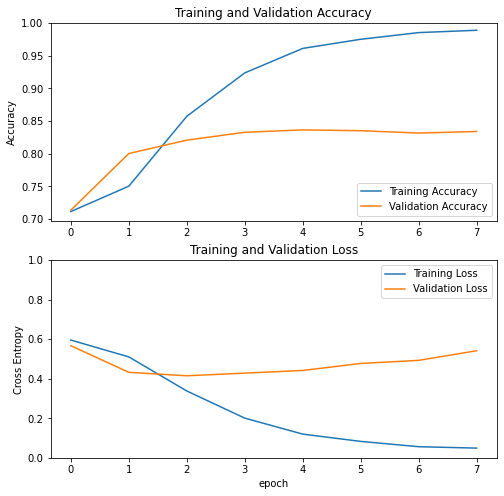

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [19]:
loaded_model = load_model('binary_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

53/53 [==============================] - 8s 160ms/step - loss: 0.4375 - acc: 0.8602

 테스트 정확도: 0.8602


In [28]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         4673536   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [29]:
y_pred = loaded_model.predict(X_test) >=0.5

In [23]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
confusion_matrix(y_test, y_pred)

array([[1114,   90],
       [ 146,  338]], dtype=int64)

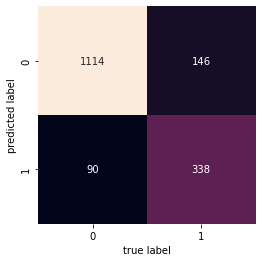

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [24]:
precision = precision_score(y_test, y_pred)
precision

0.7897196261682243

In [25]:
recall = recall_score(y_test, y_pred, average = 'weighted')
recall

0.8601895734597157

In [26]:
f1score = f1_score(y_test, y_pred, average= 'weighted')
f1score

0.8574859029305274

In [31]:
new_songs = '''
어느새 빗물이 내 발목에 고이고
참았던 눈물이 내 눈가에 고이고
I cry
어딜 가도 떠있는 내 작은 먹구름
까치발 딛고 잡아보려고 해도
키가 닿지 않아 항상 손끝 위에
어느새 빗물이 내 발목에 고이고
참았던 눈물이 내 눈가에 고이고
I cry
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 습관이 돼버린 나
난 그대 없이는 안돼요
alone in the rain
어딜 가도 내 뒤를 쫓는 나만의 먹구름
창문을 닫고 끝내 눈을 감아도
곧 나를 깨우는 차가운 한방울
어느새 빗물이 내 발목에 고이고
참았던 눈물이 내 눈가에 고이고
I cry
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 습관이 돼버린 나
난 그대 없이는 안돼요
alone in the rain
나의 곁에 그대가 없기에
내 창밖에 우산을 들고 기다리던 그대
I cry
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 습관이 돼버린 나
난 그대 없이는 안돼요
I need you back in my life
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 없는 반쪽의 세상
그댄 나 없이는 안돼요
'''

In [32]:
import re
new_songs = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_songs)
new_song_token = okt.morphs(new_songs) # 토큰화
new_encoded = tokenizer.texts_to_sequences([new_song_token]) # 인코딩
new_pad = pad_sequences(new_encoded, maxlen = 700) # 패딩
new_pred = np.argmax(loaded_model.predict(new_pad), axis=-1) # 감정 분류
new_pred

array([0], dtype=int64)